## Setup

#### Common imports

In [203]:
# Common imports

import numpy as np
from datasets import load_dataset

#### Helpers

In [204]:
def log(*args, level: int = 0, should_log: bool):
    if should_log:
        string = '\t' * level + ' '.join([str(arg) for arg in args])
        print(string)

In [205]:
def log_progress(progress: float, level: int, should_log: bool):
    progress_string = '=' * int(progress * 20)
    if len(progress_string) < 20:
        progress_string += '>'
    progress_string += ' ' * (20 - len(progress_string))
    
    log(f'Progress: [{progress_string}] - {progress * 100:.2f}%', level=level, should_log=should_log)

In [206]:
class DatasetsLoader:
    
    def load_dataset(self, dataset_name, split: str, percentage: float = 1.0):
        texts = []
        references = []
        
        if dataset_name == 'sst2':
            dataset = load_dataset('glue', 'sst2')
            data = dataset[split]
            texts = data['sentence']
            references = data['label']
        
        elif dataset_name == 'tweet_eval':
            dataset = load_dataset('tweet_eval', 'sentiment')
            data = dataset[split]
            texts = data['text']
            references = data['label']
            
        elif dataset_name == 'imdb':
            dataset = load_dataset('imdb')
            data = dataset[split]
            texts = data['text']
            references = data['label']
            
        else:
            raise Exception(f'Unknown dataset: {dataset_name}')
        
        print(f'Loaded {len(texts)} samples from {dataset_name}')
        print(f'First sample: {texts[0]} - {references[0]}')
        
        texts = texts[:int(len(texts) * percentage)]
        references = references[:len(texts)]
        
        return texts, references

## Model

#### Importing packages

In [207]:
# Importing packages

from transformers import pipeline

#### Model constants

In [208]:
# Model constants

WRAPPERS = [
        'Sentence about <mask>: "{text}".',
        '"{text}" is about <mask>.',
        'The theme of text "{text}" is the <mask>.',
        'The sentence "{text}" is on theme of <mask>.'
]

MAX_TOKEN_COUNT = 512

#### Prompt Model

In [209]:
# Prompt Model

class PromptModel:
    
    def __init__(self,
                 wrappers: list[str],
                 resulting_method: str = 'average',
                 unmasker_model_name: str = 'roberta-large',
                 sentiment_classifier_model_name: str = 'distilbert-base-uncased-finetuned-sst-2-english',
                 no_mask_threshold: float = 1.0,
                 sentiment_threshold: float = 0.5
                 ) -> None:
        
        self.__wrappers = wrappers
        self.__resulting_method = resulting_method
        self.__unmasker = pipeline('fill-mask', model=unmasker_model_name)
        self.__sentiment_classifier = pipeline(
            model=sentiment_classifier_model_name,
            task="sentiment-analysis",
            return_all_scores=True,
        )
        self.no_mask_threshold = no_mask_threshold
        self.sentiment_threshold = sentiment_threshold
        
    # Predicting sentiment with no_mask_threshold
        
    def predict_sentiment_class(self, texts: list[str], should_log: bool = False) -> list[int]:
        predictions = []
        for i, text in enumerate(texts):
            log_progress(i / len(texts), level=1, should_log=should_log)
            predictions.append(self.__predict_sentiment_class(text))
        return predictions
        
    def __predict_sentiment_class(self, text: str, should_log=False) -> int:
        score = self.predict_sentiment_with_no_mask_threshold(text, should_log=should_log)
        return int(score >= self.sentiment_threshold)
    
    # Predicting sentiment with mask
    
    def predict_sentiment_class_with_mask(self, texts: list[str], should_log: bool = False) -> list[int]:
        predictions = []
        for i, text in enumerate(texts):
            log_progress(i / len(texts), level=1, should_log=should_log)
            predictions.append(self.__predict_sentiment_class_with_mask(text))
        return predictions
        
    def __predict_sentiment_class_with_mask(self, text: str, should_log: bool = False) -> int:
        score = self.__predict_with_masks(text, should_log=should_log)
        return int(score > self.sentiment_threshold)
    
    # Predicting sentiment without mask
    
    def predict_sentiment_class_no_mask(self, texts: list[str], should_log: bool = False) -> list[int]:
        predictions = []
        for i, text in enumerate(texts):
            log_progress(i / len(texts), level=1, should_log=should_log)
            predictions.append(self.__predict_sentiment_class_no_mask(text))
        return predictions
    
    def __predict_sentiment_class_no_mask(self, text: str, should_log=False) -> int:
        score = self.predict_sentiment_without_mask(text, should_log=should_log)
        return int(score >= self.sentiment_threshold)
    
    def predict_sentiment_without_mask(self, text: str, should_log=False) -> float:
        score = self.__predict_sentiment(text)
        log('Predicting without mask:', should_log=should_log)
        log(f'Text: [{text}]', should_log=should_log)
        log(f'Sentiment score: {score}', should_log=should_log)
        return score
    
    # Private methods
        
    def predict_sentiment_with_no_mask_threshold(self, text: str, should_log=False) -> float:
        log(f'Predicting with no_mask_threshold {self.no_mask_threshold}', should_log=should_log)
        
        no_mask_prediction = self.predict_sentiment_without_mask(text, should_log=should_log)
        # if prediction is not ambiguous, return it
        if no_mask_prediction >= self.no_mask_threshold or no_mask_prediction <= 1 - self.no_mask_threshold:
            return no_mask_prediction
        
        return self.__predict_with_masks(text, should_log=should_log)
    
    def __predict_with_masks(self, text: str, should_log=False) -> float:
            
        log('Predicting with mask:', should_log=should_log)
        log(f'Text: [{text}]', should_log=should_log)
        log('-------------------', level=1, should_log=should_log)
        
        scores = []
            
        for wrapper in self.__wrap_text(text):
            masks = self.__get_masks(wrapper)
            score = self.__get_score_for_masks(masks=masks, should_log=should_log)
            scores.append(score)
            
            log(f'Wrapper: [{wrapper}]', level=1, should_log=should_log)
            log('Sentiment classification:', level=1, should_log=should_log)
            log(f'Score: {score}', level=1, should_log=should_log)
            log('-------------------', level=1, should_log=should_log)
            
        if self.__resulting_method == 'average':
            score = sum(scores) / len(scores)
        elif self.__resulting_method == 'max':
            score = max(scores)
        elif self.__resulting_method == 'min':
            score = min(scores)
        else:
            ValueError(f'Unknown resulting method ({self.__resulting_method}). Should be one of ({["average", "max", "min"]})')
            
        log(f'Prediction: {score}', should_log=should_log)
            
        return score
    
    def __get_score_for_masks(self, masks: list, should_log: bool) -> list[dict]:
        masks_scores_sum = sum(list(map(lambda x: x['score'], masks)))

        average_positive = 0.0
        
        for (_, mask) in enumerate(masks):
            text = mask['text']
            mask_score = mask['score']

            score = self.__predict_sentiment(text)
            
            log(f'Text: [{text}]', level=2, should_log=should_log)
            log(f'Mask score: [{score}]', level=2, should_log=should_log)

            average_positive += mask_score / masks_scores_sum * score
        
        return average_positive
    
    def __predict_sentiment(self, text: str):
        score_positive = 0.0

        sentiment_list = self.__sentiment_classifier(text)

        for sentiment in sentiment_list[0]:
            label = sentiment['label']
            score = sentiment['score']

            if label == 'POSITIVE':
                score_positive = score

        return score_positive

    def __wrap_text(self, text: str) -> list[str]:
        return list(map(lambda wrapper: wrapper.format(text=text), self.__wrappers))
    
    def __get_masks(self, text: str) -> str:
        masks = self.__unmasker(text)

        return list(
            map(
                lambda x: {
                    'text': x['sequence'],
                    'score': x['score']
                }, 
                masks
            )
        )

In [210]:
class Trainer:
    
    def __init__(self, model: PromptModel) -> None:
        self.__model = model
        
    def train_no_mask_threshold(self, texts: list, should_log=False):
        log(f'Training no_mask_threshold', should_log=should_log)
        scores = []
        
        for i, text in enumerate(texts):
            log_progress(i / len(texts), level=1, should_log=should_log)
            score = self.__model.predict_sentiment_without_mask(text, should_log=False)
            scores.append(score)
        
        scores.sort()
        
        count = int(len(scores) * 0.1)
        top_10_percent = scores[-count]
        bottom_10_percent = scores[count]
        
        no_mask_threshold = (top_10_percent + (1 - bottom_10_percent)) / 2
        
            
        log(f'Threshold: {no_mask_threshold}', should_log=should_log)
        self.__model.no_mask_threshold = no_mask_threshold
        
    def train_sentiment_threshold(self, texts: list, references: list, should_log=False):
        log(f'Training sentiment threshold', should_log=should_log)
        
        best_count = 0
        best_threshold = 0.0
        
        for threshold in np.arange(0.0, 1.0, 0.01):
            log_progress(threshold, level=1, should_log=should_log)
            self.__model.sentiment_threshold = threshold
            predictions = self.__model.predict_sentiment_class(texts, should_log=False)
            count = sum(list(map(lambda x: int(x[0] == x[1]), zip(predictions, references))))
            if count > best_count:
                best_count = count
                best_threshold = threshold
                
        log(f'Best threshold: {best_threshold}', should_log=should_log)
        self.__model.sentiment_threshold = best_threshold

#### Evaluating results

In [211]:
from evaluate import load

def evaluate_accuracy(predictions, references):
    
    if len(predictions) != len(references):
        raise ValueError('Length of texts and references should be equal')
    
    log('Evaluating accuracy', should_log=True)
        
    precision_metric = load("accuracy")
    accuracy = precision_metric.compute(references=references, predictions=predictions)['accuracy']
    
    log(f'Accuracy ~= {accuracy}', should_log=True)
    
    return accuracy

In [212]:
def disclaim_results(predictions: list[int], compared_predictions: list[int], references: list[int], texts: list[str]):
    same_mistake = []
    corrected = []
    new_mistake = []
        
    for i in range(len(predictions)):
        prediction = predictions[i]
        compared_prediction = compared_predictions[i]
        reference = references[i]
        text = texts[i]
        
        if prediction == compared_prediction:
            if prediction != reference:
                same_mistake.append({
                    'text': text,
                    'prediction': prediction,
                    'compared_prediction': compared_prediction,
                    'reference': reference
                })
        else:
            if prediction == reference:
                corrected.append({
                    'text': text,
                    'prediction': prediction,
                    'compared_prediction': compared_prediction,
                    'reference': reference
                })
            else:
                new_mistake.append({
                    'text': text,
                    'prediction': prediction,
                    'compared_prediction': compared_prediction,
                    'reference': reference
                })
                
    return (same_mistake, corrected, new_mistake)


## Trying out the model on `tweet_eval` dataset

The model `distilbert-base-uncased-finetuned-sst-2-english` was trained on the SST-2 dataset. That is too prepared to be improved by such simple fine-tuning. Let's try to fine-tune it on another dataset

#### `tweet_eval` dataset

In [213]:
# load test dataset

texts, references = DatasetsLoader().load_dataset('tweet_eval', 'validation', percentage=0.1)
    
# leave only positive and negative labels

idx = [i for i, label in enumerate(references) if label != 1]

texts, references = [texts[i] for i in idx], [references[i] for i in idx]

for i in range(len(references)):
    references[i] = 1 if references[i] == 2 else 0
    
print(f'After filtering: total of {len(references)} texts')

Found cached dataset tweet_eval (/Users/heartsker/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
100%|██████████| 3/3 [00:00<00:00, 347.67it/s]

Loaded 2000 samples from tweet_eval
First sample: Dark Souls 3 April Launch Date Confirmed With New Trailer: Embrace the darkness. - 1
After filtering: total of 114 texts


#### Create and train model

In [214]:
SHOULD_TRAIN_TWEEN_EVAL = False
if SHOULD_TRAIN_TWEEN_EVAL:
    model = PromptModel(WRAPPERS)
    trainer = Trainer(model)

    trainer.train_no_mask_threshold(texts=texts, should_log=True)
    trainer.train_sentiment_threshold(texts=texts, references=references, should_log=True)
    
else:
    model = PromptModel(WRAPPERS, no_mask_threshold=0.9991778972907923, sentiment_threshold=0.3)

# no_mask_threshold = 0.9991778972907923
# sentiment_threshold = 0.3

/opt/homebrew/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


#### Evaluate model

In [215]:
predictions_prompt_model = model.predict_sentiment_class(texts, should_log=True)
combined_accuracy = evaluate_accuracy(predictions=predictions_prompt_model, references=references)

predictions_distilbert = model.predict_sentiment_class_no_mask(texts, should_log=True)
no_mask_accuracy = evaluate_accuracy(predictions=predictions_distilbert, references=references)

print(f'''
      Evaluated accuracy:
      [Combined] accuracy = {combined_accuracy}
      [No mask] accuracy = {no_mask_accuracy}
      ''')

# [Combined] accuracy = 0.868421052631579
# [No mask] accuracy = 0.8245614035087719

	Progress: [>                   ] - 0.00%
	Progress: [>                   ] - 0.88%
	Progress: [>                   ] - 1.75%
	Progress: [>                   ] - 2.63%
	Progress: [>                   ] - 3.51%
	Progress: [>                   ] - 4.39%
	Progress: [=>                  ] - 5.26%
	Progress: [=>                  ] - 6.14%
	Progress: [=>                  ] - 7.02%
	Progress: [=>                  ] - 7.89%
	Progress: [=>                  ] - 8.77%
	Progress: [=>                  ] - 9.65%
	Progress: [==>                 ] - 10.53%
	Progress: [==>                 ] - 11.40%
	Progress: [==>                 ] - 12.28%
	Progress: [==>                 ] - 13.16%
	Progress: [==>                 ] - 14.04%
	Progress: [==>                 ] - 14.91%
	Progress: [===>                ] - 15.79%
	Progress: [===>                ] - 16.67%
	Progress: [===>                ] - 17.54%
	Progress: [===>                ] - 18.42%
	Progress: [===>                ] - 19.30%
	Progress: [====>      

In [216]:
same_mistake, corrected, new_mistake = disclaim_results(predictions_prompt_model, predictions_distilbert, references, texts)

print(f'Number of same mistakes: {len(same_mistake)}')
print(f'Number of corrected mistakes: {len(corrected)}')
print(f'Number of new mistakes: {len(new_mistake)}')

import json
print('Same mistake:')
print(json.dumps(same_mistake, indent=4))
print('--------------------------------')
print('Corrected:')
print(json.dumps(corrected, indent=4))
print('--------------------------------')
print('New mistake:')
print(json.dumps(new_mistake, indent=4))

Number of same mistakes: 12
Number of corrected mistakes: 8
Number of new mistakes: 3
Same mistake:
[
    {
        "text": "\"\\\"\"@Bobbieliciouss: Don\\u2019t think i\\u2019m going to school tomorrow.\\\"\" School\\u2019s gonna crack tomorrow\"",
        "prediction": 1,
        "compared_prediction": 1,
        "reference": 0
    },
    {
        "text": "tomorrow I've to wake up  early so Zayn's erformance on VMA better be true otherwise u'll regret for playing with my emotions and sleep",
        "prediction": 0,
        "compared_prediction": 0,
        "reference": 1
    },
    {
        "text": "@user told you because you said \"\"Generally 15 August comes near Eid week\"\". It happens for only 2 years after every 30 years. :)\"",
        "prediction": 0,
        "compared_prediction": 0,
        "reference": 1
    },
    {
        "text": "Hey @user please RT, running GNR on Sunday, anyone got suggestions for good running songs.  Need to update the iPod.",
        "prediction

In [217]:
for item in same_mistake:
    sentiment_combined = model.predict_sentiment_with_no_mask_threshold(text=item['text'], should_log=False)
    sentiment_no_mask = model.predict_sentiment_without_mask(text=item['text'], should_log=False)
    
    print(f'''
        Text: {item['text']}
        Reference: {item['reference']}
        Prediction: {item['prediction']}
        Compared prediction: {item['compared_prediction']}
        Sentiment combined: {sentiment_combined}
        Sentiment no mask: {sentiment_no_mask}
    ''')


        Text: "\""@Bobbieliciouss: Don\u2019t think i\u2019m going to school tomorrow.\"" School\u2019s gonna crack tomorrow"
        Reference: 0
        Prediction: 1
        Compared prediction: 1
        Sentiment combined: 0.5690427146793758
        Sentiment no mask: 0.9462880492210388
    

        Text: tomorrow I've to wake up  early so Zayn's erformance on VMA better be true otherwise u'll regret for playing with my emotions and sleep
        Reference: 1
        Prediction: 0
        Compared prediction: 0
        Sentiment combined: 0.18428491962795254
        Sentiment no mask: 0.0013990665320307016
    

        Text: @user told you because you said ""Generally 15 August comes near Eid week"". It happens for only 2 years after every 30 years. :)"
        Reference: 1
        Prediction: 0
        Compared prediction: 0
        Sentiment combined: 0.2170249149288583
        Sentiment no mask: 0.01582617312669754
    

        Text: Hey @user please RT, running GNR on Sund

In [218]:
positive_texts = [text for i, text in enumerate(texts) if references[i] == 1]
negative_texts = [text for i, text in enumerate(texts) if references[i] == 0]

positive_count = len(positive_texts)
negative_count = len(negative_texts)

positive_predictions_prompt_model = [model.predict_sentiment_with_no_mask_threshold(text, should_log=False) for text in positive_texts]
positive_predictions_distilbert = [model.predict_sentiment_without_mask(text, should_log=False) for text in positive_texts]

positive_classes_prompt_model = list(map(lambda x: int( x >= model.sentiment_threshold), positive_predictions_prompt_model))
positive_classes_distilbert = list(map(lambda x: int( x >= model.sentiment_threshold), positive_predictions_distilbert))

negative_predictions_prompt_model = [model.predict_sentiment_with_no_mask_threshold(text, should_log=False) for text in negative_texts]
negative_predictions_distilbert = [model.predict_sentiment_without_mask(text, should_log=False) for text in negative_texts]

negative_classes_prompt_model = list(map(lambda x: int( x >= model.sentiment_threshold), negative_predictions_prompt_model))
negative_classes_distilbert = list(map(lambda x: int( x >= model.sentiment_threshold), negative_predictions_distilbert))

In [219]:
positive_count = len(positive_texts)
negative_count = len(negative_texts)

In [220]:
fp_combined = sum([prediction != 1 for prediction in positive_classes_prompt_model])
fp_no_mask = sum([prediction != 1 for prediction in positive_classes_distilbert])

fn_combined = sum([prediction != 0 for prediction in negative_classes_prompt_model])
fn_no_mask = sum([prediction != 0 for prediction in negative_classes_distilbert])

fp_rate_combined = fp_combined / positive_count
fp_rate_no_mask = fp_no_mask / positive_count
fn_rate_combined = fn_combined / negative_count
fn_rate_no_mask = fn_no_mask / negative_count

print(f'''
        Positive texts: {positive_count}
        Negative texts: {negative_count}
        | Metric                | Combined  | No mask   |
        | --------------------- | --------- | --------- |
        | False positives       | {fp_combined} | {fp_no_mask} |
        | False negatives       | {fn_combined} | {fn_no_mask} |
        | False positive rate   | {fp_rate_combined} | {fp_rate_no_mask} |
        | False negative rate   | {fn_rate_combined} | {fn_rate_no_mask} |
        ''')


        Positive texts: 82
        Negative texts: 32
        | Metric                | Combined  | No mask   |
        | --------------------- | --------- | --------- |
        | False positives       | 13 | 19 |
        | False negatives       | 2 | 1 |
        | False positive rate   | 0.15853658536585366 | 0.23170731707317074 |
        | False negative rate   | 0.0625 | 0.03125 |
        


/var/folders/nn/q47c3s4s57v6xbd1p5l849200000gn/T/ipykernel_69864/29996846.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(
/var/folders/nn/q47c3s4s57v6xbd1p5l849200000gn/T/ipykernel_69864/29996846.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


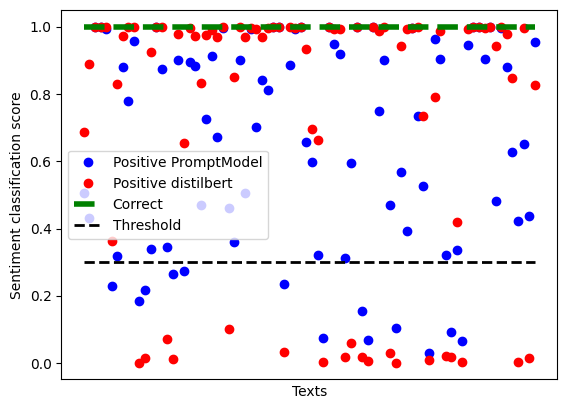

In [221]:
from matplotlib import pyplot as plt

plt.plot(
    [i for i in range(positive_count)],
    positive_predictions_prompt_model,
    'ro',
    label='Positive PromptModel',
    color='blue'
)

plt.plot(
    [i for i in range(positive_count)],
    positive_predictions_distilbert,
    'ro',
    label='Positive distilbert',
    color='red'
)    

plt.plot(
    [0, positive_count - 1],
    [1, 1],
    color='green',
    label='Correct',
    linewidth=4,
    linestyle='dashed'
)    


plt.plot(
    [0, positive_count - 1], 
    [model.sentiment_threshold, model.sentiment_threshold], 
    color='black', 
    label='Threshold', 
    linewidth=2, 
    linestyle='dashed'
)

plt.xlabel('Texts')
plt.xticks([])
plt.ylabel('Sentiment classification score')
plt.legend()

plt.savefig('sentiment_classification_positive.png', dpi=600)

plt.show()

/var/folders/nn/q47c3s4s57v6xbd1p5l849200000gn/T/ipykernel_69864/2777306357.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(
/var/folders/nn/q47c3s4s57v6xbd1p5l849200000gn/T/ipykernel_69864/2777306357.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


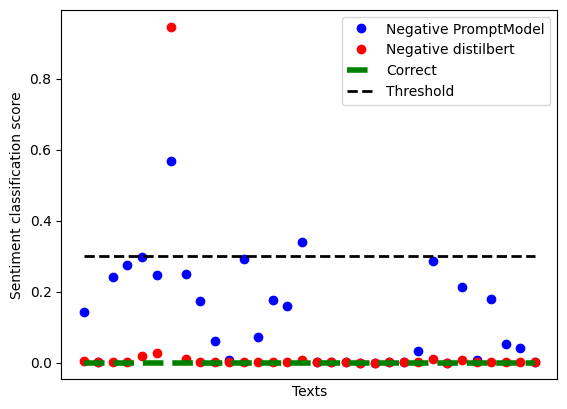

In [222]:
import matplotlib.pyplot as plt

plt.plot(
    [i for i in range(negative_count)], 
    negative_predictions_prompt_model, 
    'ro', 
    label='Negative PromptModel',
    color='blue'
)
plt.plot(
    [i for i in range(negative_count)],
    negative_predictions_distilbert, 
    'ro',
    label='Negative distilbert',
    color='red'
)

plt.plot(
    [0, negative_count - 1], 
    [0, 0], 
    color='green', 
    label='Correct', 
    linewidth=4, 
    linestyle='dashed'
)
plt.plot(
    [0, negative_count - 1], 
    [model.sentiment_threshold, model.sentiment_threshold], 
    color='black', 
    label='Threshold', 
    linewidth=2, 
    linestyle='dashed'
)

plt.xlabel('Texts')
plt.xticks([])
plt.ylabel('Sentiment classification score')

plt.legend()

plt.savefig('sentiment_classification_negative.png', dpi=600)

plt.show()

In [223]:
fn_blowout_idx = [i for i, prediction in enumerate(negative_predictions_prompt_model) if prediction >= model.sentiment_threshold]

for idx in fn_blowout_idx:
    print(f'''
        idx: {idx}
        Text: {negative_texts[idx]}
        Reference: {references[idx]}
        PromptModel prediction: {negative_predictions_prompt_model[idx]}
        distilbert prediction: {negative_predictions_distilbert[idx]}
    ''')


        idx: 6
        Text: "\""@Bobbieliciouss: Don\u2019t think i\u2019m going to school tomorrow.\"" School\u2019s gonna crack tomorrow"
        Reference: 1
        PromptModel prediction: 0.5690427146793758
        distilbert prediction: 0.9462880492210388
    

        idx: 15
        Text: "Judging by the traffic and complaining, I think I might be best setting for Foo Fighters' Milton Keynes gig tomorrow right now"
        Reference: 1
        PromptModel prediction: 0.34019449173654104
        distilbert prediction: 0.006443369202315807
    


In [224]:
model.predict_sentiment_with_no_mask_threshold(negative_texts[6], should_log=True)

Predicting with no_mask_threshold 0.9991778972907923
Predicting without mask:
Text: ["\""@Bobbieliciouss: Don\u2019t think i\u2019m going to school tomorrow.\"" School\u2019s gonna crack tomorrow"]
Sentiment score: 0.9462880492210388
Predicting with mask:
Text: ["\""@Bobbieliciouss: Don\u2019t think i\u2019m going to school tomorrow.\"" School\u2019s gonna crack tomorrow"]
	-------------------
		Text: [Sentence about school: ""\""@Bobbieliciouss: Don\u2019t think i\u2019m going to school tomorrow.\"" School\u2019s gonna crack tomorrow"".]
		Mask score: [0.6367256045341492]
		Text: [Sentence about bullying: ""\""@Bobbieliciouss: Don\u2019t think i\u2019m going to school tomorrow.\"" School\u2019s gonna crack tomorrow"".]
		Mask score: [0.08153968304395676]
		Text: [Sentence about Twitter: ""\""@Bobbieliciouss: Don\u2019t think i\u2019m going to school tomorrow.\"" School\u2019s gonna crack tomorrow"".]
		Mask score: [0.45741933584213257]
		Text: [Sentence about Snapchat: ""\""@Bobbielic

0.5690427146793758

In [225]:
stop()

NameError: name 'stop' is not defined

## Trying out the model on `glue sst2` dataset

#### Preparing the data

In [ ]:
texts, references = DatasetsLoader().load_dataset(dataset_name='sst2', split='validation', percentage=0.1)

Found cached dataset glue (/Users/heartsker/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 274.42it/s]

Loaded 872 samples from sst2
First sample: it 's a charming and often affecting journey .  - 1


#### Creating the model and training parameters

In [ ]:
model = PromptModel(WRAPPERS)
trainer = Trainer(model)


trainer.train_no_mask_threshold(texts[:1000], should_log=True)
trainer.train_sentiment_threshold(texts[:100], references=references, should_log=True)

# no_mask_threshold = 0.9997753630159423
# sentiment_threshold = ???

/opt/homebrew/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Training no_mask_threshold
	Progress: [>                   ] - 0.00%
	Progress: [>                   ] - 1.15%
	Progress: [>                   ] - 2.30%
	Progress: [>                   ] - 3.45%
	Progress: [>                   ] - 4.60%
	Progress: [=>                  ] - 5.75%
	Progress: [=>                  ] - 6.90%
	Progress: [=>                  ] - 8.05%
	Progress: [=>                  ] - 9.20%
	Progress: [==>                 ] - 10.34%
	Progress: [==>                 ] - 11.49%
	Progress: [==>                 ] - 12.64%
	Progress: [==>                 ] - 13.79%
	Progress: [==>                 ] - 14.94%
	Progress: [===>                ] - 16.09%
	Progress: [===>                ] - 17.24%
	Progress: [===>                ] - 18.39%
	Progress: [===>                ] - 19.54%
	Progress: [====>               ] - 20.69%
	Progress: [====>               ] - 21.84%
	Progress: [====>               ] - 22.99%
	Progress: [====>               ] - 24.14%
	Progress: [=====>              ] - 

KeyboardInterrupt: 

#### Running the model on the sst-2 dataset

In [ ]:
predictions = model.predict_sentiment_class(texts, should_log=True)

evaluate_accuracy(predictions=predictions, references=references)

# Accuracy ~= 0.9310344827586207

In [ ]:
predictions = model.predict_sentiment_class_no_mask(texts, should_log=True)

evaluate_accuracy(predictions=predictions, references=references)

# Accuracy ~= 0.9770114942528736

## Trying out the model on `imdb` dataset

In [ ]:
# load test dataset

texts, references = DatasetsLoader().load_dataset('imdb', 'test', percentage=1.0)
    
# leave only positive and negative labels

idx = [i for i, text in enumerate(texts) if len(text) <= MAX_TOKEN_COUNT]

texts, references = [texts[i] for i in idx], [references[i] for i in idx]

print(len(texts))

Found cached dataset imdb (/Users/heartsker/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 152.44it/s]

Loaded 25000 samples from imdb
First sample: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of 

#### Create and train model

In [ ]:
model = PromptModel(WRAPPERS)
trainer = Trainer(model)

trainer.train_no_mask_threshold(texts=texts[:1000], should_log=True)
trainer.train_sentiment_threshold(texts=texts[:100], references=references, should_log=True)

# no_mask_threshold = 0.9713988811854506
# sentiment_threshold = 0.3

/Users/heartsker/Library/Python/3.9/lib/python/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Training no_mask_threshold
	Progress: [>                   ] - 0.00%
	Progress: [>                   ] - 0.10%
	Progress: [>                   ] - 0.20%
	Progress: [>                   ] - 0.30%
	Progress: [>                   ] - 0.40%
	Progress: [>                   ] - 0.50%
	Progress: [>                   ] - 0.60%
	Progress: [>                   ] - 0.70%
	Progress: [>                   ] - 0.80%
	Progress: [>                   ] - 0.90%
	Progress: [>                   ] - 1.00%
	Progress: [>                   ] - 1.10%
	Progress: [>                   ] - 1.20%
	Progress: [>                   ] - 1.30%
	Progress: [>                   ] - 1.40%
	Progress: [>                   ] - 1.50%
	Progress: [>                   ] - 1.60%
	Progress: [>                   ] - 1.70%
	Progress: [>                   ] - 1.80%
	Progress: [>                   ] - 1.90%
	Progress: [>                   ] - 2.00%
	Progress: [>                   ] - 2.10%
	Progress: [>                   ] - 2.20%
	Progre

#### Evaluate model

In [ ]:
predictions = model.predict_sentiment_class(texts, should_log=True)
combined_accuracy = evaluate_accuracy(predictions=predictions, references=references)

predictions = model.predict_sentiment_class_no_mask(texts, should_log=True)
no_mask_accuracy = evaluate_accuracy(predictions=predictions, references=references)

predictions = model.predict_sentiment_class_with_mask(texts, should_log=True)
mask_accuracy = evaluate_accuracy(predictions= predictions, references=references)

print(f'''
      Evaluated accuracy:
      [Combined] accuracy = {combined_accuracy}
      [No mask] accuracy = {no_mask_accuracy}
      [Mask] accuracy = {mask_accuracy}
      ''')

In [ ]:
# with pretrained thesholds

model = PromptModel(WRAPPERS, no_mask_threshold=0.9713988811854506, sentiment_threshold=0.3)

predictions = model.predict_sentiment_class(texts, should_log=True)
combined_accuracy = evaluate_accuracy(predictions=predictions, references=references)

predictions = model.predict_sentiment_class_no_mask(texts, should_log=True)
no_mask_accuracy = evaluate_accuracy(predictions=predictions, references=references)

predictions = model.predict_sentiment_class_with_mask(texts, should_log=True)
mask_accuracy = evaluate_accuracy(predictions= predictions, references=references)

print(f'''
      Evaluated accuracy:
      [Combined] accuracy = {combined_accuracy}
      [No mask] accuracy = {no_mask_accuracy}
      [Mask] accuracy = {mask_accuracy}
      ''')

      # Evaluated accuracy:
      # [Combined] accuracy = 0.9049773755656109
      # [No mask] accuracy = 0.9061085972850679
      # [Mask] accuracy = 0.9034690799396682

	Progress: [>                   ] - 0.00%
	Progress: [>                   ] - 0.04%
	Progress: [>                   ] - 0.08%
	Progress: [>                   ] - 0.11%
	Progress: [>                   ] - 0.15%
	Progress: [>                   ] - 0.19%
	Progress: [>                   ] - 0.23%
	Progress: [>                   ] - 0.26%
	Progress: [>                   ] - 0.30%
	Progress: [>                   ] - 0.34%
	Progress: [>                   ] - 0.38%
	Progress: [>                   ] - 0.41%
	Progress: [>                   ] - 0.45%
	Progress: [>                   ] - 0.49%
	Progress: [>                   ] - 0.53%
	Progress: [>                   ] - 0.57%
	Progress: [>                   ] - 0.60%
	Progress: [>                   ] - 0.64%
	Progress: [>                   ] - 0.68%
	Progress: [>                   ] - 0.72%
	Progress: [>                   ] - 0.75%
	Progress: [>                   ] - 0.79%
	Progress: [>                   ] - 0.83%
	Progress: [>                   ] 